In [43]:
import os
import pathlib
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide TensorFlow Warning due to using GPU
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from sklearn.metrics import classification_report

In [18]:
data_dir = "../dataset/kagglegc"
data_dir = pathlib.Path(data_dir) #pathlib.Path respect different semantics appropriate for different operating systems

In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

15515


In [20]:
batch_size = 32
img_height = 150
img_width = 150

In [22]:
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds_size = tf.data.experimental.cardinality(ds).numpy()
print(ds_size)

Found 15515 files belonging to 10 classes.
485


In [23]:
class_names = ds.class_names
print(class_names)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [24]:
# Keras Apllications Pretrained Model Preprocessing
def preprocess(images, labels):
    return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels
    # inception_resnet_v2.preprocess_input will scale input pixels between -1 and 1.

# Apply preprocess
ds = ds.map(preprocess)

In [25]:
# Split dataset
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=15515):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=123)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1)

In [26]:
# Configure dataset for performance  
# https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
inception_resnet_v2 = load_model('../saved_models/Trash Classifier/inception_resnet_v2_kagglegc.h5')
inception_resnet_v2 = Model(
    inputs=inception_resnet_v2.inputs,
    outputs=inception_resnet_v2.outputs
)
mobile_net_v2 = load_model('../saved_models/Trash Classifier/mobile_net_v2_kagglegc.h5')
mobile_net_v2 = Model(
    inputs=mobile_net_v2.inputs,
    outputs=mobile_net_v2.outputs
)

models = [inception_resnet_v2, mobile_net_v2]
model_input = Input(shape=(150,150,3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output)

In [28]:
ensemble_model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [29]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 tl_inception_resnet_v2 (Functi  (None, 10)          54764394    ['input_4[0][0]']                
 onal)                                                                                            
                                                                                                  
 tl_mobile_net_v2 (Functional)  (None, 10)           2620106     ['input_4[0][0]']                
                                                                                           

In [31]:
epochs=5
history = ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


2023-06-16 01:56:12.647791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [15515]
	 [[{{node Placeholder/_0}}]]
2023-06-16 01:56:12.648030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [15515]
	 [[{{node Placeholder/_0}}]]
2023-06-16 01:56:28.545794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 26 of 15515
2023-06-16 01:56:38.660195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 15515
2023-06-16 0

388/388 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9725

2023-06-16 01:59:35.146201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [15515]
	 [[{{node Placeholder/_4}}]]
2023-06-16 01:59:35.146511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [15515]
	 [[{{node Placeholder/_0}}]]
2023-06-16 01:59:47.295559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 351 of 15515
2023-06-16 01:59:57.267427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 388 of 15515
2023-06-16 

388/388 [==============================] - 260s 302ms/step - loss: 0.1074 - accuracy: 0.9725 - val_loss: 0.0867 - val_accuracy: 0.9740
Epoch 2/5
388/388 [==============================] - 68s 175ms/step - loss: 0.0900 - accuracy: 0.9743 - val_loss: 0.0721 - val_accuracy: 0.9766
Epoch 3/5
388/388 [==============================] - 69s 179ms/step - loss: 0.0773 - accuracy: 0.9771 - val_loss: 0.0605 - val_accuracy: 0.9824
Epoch 4/5
388/388 [==============================] - 69s 178ms/step - loss: 0.0914 - accuracy: 0.9696 - val_loss: 0.0778 - val_accuracy: 0.9688
Epoch 5/5
388/388 [==============================] - 69s 178ms/step - loss: 0.0824 - accuracy: 0.9740 - val_loss: 0.0712 - val_accuracy: 0.9798


In [37]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(ensemble_model.predict(x), axis = -1)])
  labels = np.concatenate([labels, y.numpy()])

2023-06-16 02:11:21.616922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [15515]
	 [[{{node Placeholder/_0}}]]
2023-06-16 02:11:21.619999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [15515]
	 [[{{node Placeholder/_0}}]]
2023-06-16 02:11:31.992074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 27 of 15515
2023-06-16 02:11:41.704487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 60 of 15515
2023-06-16 0

1/1 [==============================] - 0s 62ms/step


In [40]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        86
         1.0       1.00      0.98      0.99        97
         2.0       1.00      0.99      0.99        90
         3.0       0.98      1.00      0.99       518
         4.0       0.98      0.97      0.98       207
         5.0       0.98      0.96      0.97        92
         6.0       0.99      0.93      0.96       115
         7.0       0.88      0.95      0.91        66
         8.0       0.99      0.97      0.98       230
         9.0       1.00      0.96      0.98        67

    accuracy                           0.98      1568
   macro avg       0.97      0.97      0.97      1568
weighted avg       0.98      0.98      0.98      1568



In [41]:
confusion_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
print(confusion_matrix)

[[ 86   0   0   0   0   0   0   0   0   0]
 [  0  95   0   2   0   0   0   0   0   0]
 [  0   0  89   0   0   0   1   0   0   0]
 [  0   0   0 517   0   0   0   0   1   0]
 [  0   0   0   0 201   1   0   5   0   0]
 [  1   0   0   1   1  88   0   0   1   0]
 [  3   0   0   2   0   0 107   2   1   0]
 [  0   0   0   1   1   1   0  63   0   0]
 [  0   0   0   6   0   0   0   1 223   0]
 [  0   0   0   0   2   0   0   1   0  64]]


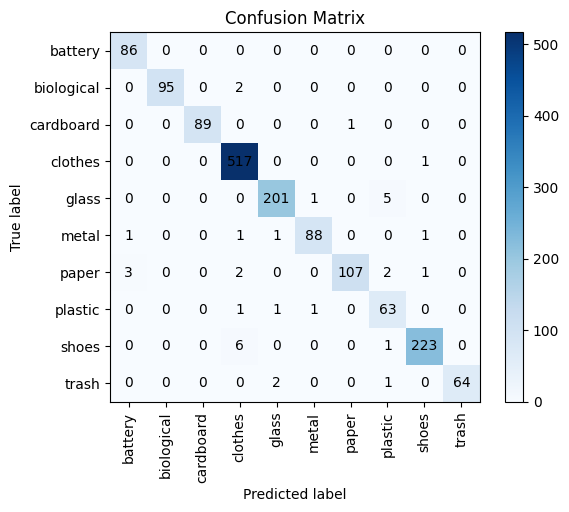

In [44]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=90)  # Rotate x-axis labels vertically
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

# Add the value annotations to the plot
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

# Display the colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

In [46]:
ensemble_model.save('../saved_models/Trash Classifier/ensemble_kagglegc/')

2023-06-16 02:20:00.933415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1536]
	 [[{{node inputs}}]]
2023-06-16 02:20:00.940472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-06-16 02:20:03.872319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2023-06-16 02:

INFO:tensorflow:Assets written to: ../saved_models/Trash Classifier/ensemble_kagglegc/assets


INFO:tensorflow:Assets written to: ../saved_models/Trash Classifier/ensemble_kagglegc/assets


In [45]:
ensemble_model.save('../saved_models/Trash Classifier/ensemble_kagglegc.h5')

ValueError: Unable to create dataset (name already exists)